# 로지스틱 회귀: 타이타닉 생존자 예측하기

로지스틱 회귀 분석 모델로 타이타닉 데이터셋을 분석해 생존자를 예측, 또한 작동 원리를 이해하고 분류 문제를 예측/평가

- 로지스틱 회귀 분석은 선형 회귀 분석과 상당히 유사
- 선형 회귀 분석은 연속된 변수를 예측하는 반면, 로지스틱 회귀 분석은 Yes/No와 같은 분류를 다룸

- 장점
    - 선형 회귀 분석만큼 구현하기 용이함
    - 계수(기울기)를 사용해 각 변수의 중요성을 쉽게 파악
- 단점
    - 선형 회귀 분석을 근간으로 하고 있기 때문에, 선형관계가 아닌 데이터에 대한 예측력이 떨어짐

## 문제 정의

- 이름, 성별, 나이, 티켓 번호 등 같은 정보가 실제로 생존에 어떤 영향을 미치는지 확인
- 종속변수(Survived), 평가지표(정확도)

## 코드 실행

In [1]:
# 라이브러리 및 데이터 불러오기
import pandas as pd
file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/titanic.csv'

data=pd.read_csv(file_url)

In [2]:
# 데이터 확인하기
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Survived
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,S,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,S,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,S,0


- Pclass: 티켓 클래스
- Name: 승객 이름
- Sex: 성별
- Age: 나이
- SibSp: 함께 탑승한 형제 및 배우자의 수
- Parch: 함께 탑승한 부모 및 자녀의 수
- Ticket: 티켓 번호
- Embarked: 승선한 항구(C=Cherbourg, Q=Queenstown, S=Southampton)
- Survived: 생존유무(1=생존, 0=사망)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Name      889 non-null    object 
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  889 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 62.6+ KB


Null 값이 없고, object 타입 4개(Name, Sex, Ticket, Embarked)

In [4]:
data.describe()

,Pclass,Age,SibSp,Parch,Survived
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,29.315152,0.524184,0.382452,0.382452
std,0.834700,12.984932,1.103705,0.806761,0.486260
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,0.000000
75%,3.000000,35.000000,1.000000,0.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,1.000000


- Pclass는 1,2,3 세 가지 값이 있음
- Age는 대부분 35세 미만이지만 최고 80세
- Sibsp와 Parch를 통해 대부분 혼자 탑승

In [5]:
# 상관관계 출력
data.corr()

,Pclass,Age,SibSp,Parch,Survived
Pclass,1.000000,-0.336512,0.081656,0.016824,-0.335549
Age,-0.336512,1.000000,-0.232543,-0.171485,-0.069822
SibSp,0.081656,-0.232543,1.000000,0.414542,-0.034040
Parch,0.016824,-0.171485,0.414542,1.000000,0.083151
Survived,-0.335549,-0.069822,-0.034040,0.083151,1.000000


- 상관관계는 수치형 변수간의 관계를 보여줌
- 0이면 상관관계가 없고, 1인 경우 상관관계가 매우 큼
- -1~1 사이의 값으로 크기는 절댓값으로 판단

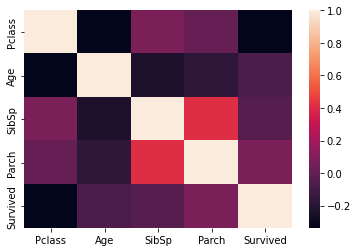

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(data.corr())
plt.show()

히트맵을 통해 색으로 상관관계 확인

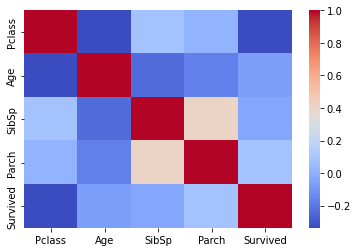

In [7]:
sns.heatmap(data.corr(), cmap='coolwarm')
plt.show()

<AxesSubplot:>

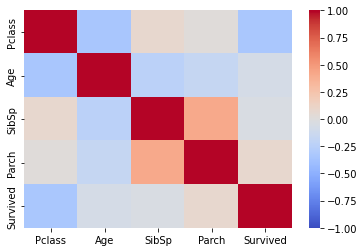

In [8]:
sns.heatmap(data.corr(),cmap='coolwarm', vmin=-1, vmax=1) # 최대, 최소 범위 지정

<AxesSubplot:>

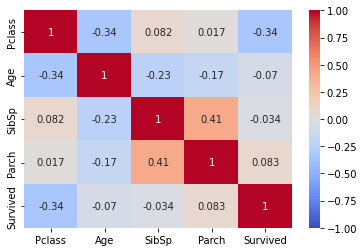

In [9]:
sns.heatmap(data.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True) # 각 값을 칸에 표시

## 전처리

### 범주형 변수 변환하기
- 머신러닝 알고리즘에서는 문자열로 된 데이터를 이해하지 못함
> catboost의 경우는 자동으로 인코딩 되기에 예외
- object 컬럼들을 숫자 데이터로 변환
- 봄, 여름, 가을, 겨울을 1,2,3,4 로 변환하는 방법이 있지만, 이럴 경우 겨울이 크다고 인식
- 이를 방지하기 위해 더미 변수를 사용 -> 원-핫 인코딩

In [10]:
# 범주가 수백, 수천 가지라면 하나씩 만들어주기는 힘들기에 고윳값의 개수 확인
data['Name'].nunique()

889

In [11]:
data['Sex'].nunique()

2

In [12]:
data['Ticket'].nunique()

680

In [13]:
data['Embarked'].nunique()

3

In [14]:
# 고윳값을 확인하고 싶다면 unique() 사용
data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

- Name과 Ticket의 고윳값을 더미 변수로 변환하면 너무 많은 칼럼이 생김
- Name 과, Ticket에 따라 사망 여부가 갈린다고 추론하기 어려우므로 제외

In [15]:
data=data.drop(['Name', 'Ticket'], axis=1)

In [16]:
data.head() # 잘 제거되었는지 확인

,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,3,male,22.0,1,0,S,0
1,1,female,38.0,1,0,C,1
2,3,female,26.0,0,0,S,1
3,1,female,35.0,1,0,S,1
4,3,male,35.0,0,0,S,0


In [17]:
# Sex와 Embarked의 원-핫 인코딩(저장 X)
pd.get_dummies(data, columns=['Sex', 'Embarked'])

,Pclass,Age,SibSp,Parch,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,0,1,0,0,1
1,1,38.0,1,0,1,1,0,1,0,0
2,3,26.0,0,0,1,1,0,0,0,1
3,1,35.0,1,0,1,1,0,0,0,1
4,3,35.0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
884,2,27.0,0,0,0,0,1,0,0,1
885,1,19.0,0,0,1,1,0,0,0,1
886,3,28.0,1,2,0,1,0,0,0,1
887,1,26.0,0,0,1,0,1,1,0,0


- Sex_female이 0이면 이 승객은 male이라는 것을 알 수 있기에 둘 중 하나만 남김
- Embarked도 2개가 0이면 나머지는 1이라는 것을 알 수 있음
- 그렇기에 고윳값 개수를 하나씩 줄여 계산량을 줄임

In [18]:
pd.get_dummies(data, columns = ['Sex', 'Embarked'], drop_first=True) # 저장 X

,Pclass,Age,SibSp,Parch,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,1,0,1
1,1,38.0,1,0,1,0,0,0
2,3,26.0,0,0,1,0,0,1
3,1,35.0,1,0,1,0,0,1
4,3,35.0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...
884,2,27.0,0,0,0,1,0,1
885,1,19.0,0,0,1,0,0,1
886,3,28.0,1,2,0,0,0,1
887,1,26.0,0,0,1,1,0,0


In [19]:
# data에 저장
data= pd.get_dummies(data, columns = ['Sex', 'Embarked'], drop_first=True)

## 모델링 및 예측

In [20]:
# train, test 분리
from sklearn.model_selection import train_test_split

# 종속변수 분리 후 저장
X=data.drop('Survived', axis=1)
y=data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [21]:
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

model = LogisticRegression()
model.fit(X_train, y_train) # 모델 학습

LogisticRegression()

In [22]:
pred=model.predict(X_test) # 예측

## 예측 모델 평가

- 이진 분류에서는 RMSE는 적합하지 않음
- 정확도: 예측값과 실제값을 비교하여 얼마나 맞추었는지 확인

In [23]:
from sklearn.metrics import accuracy_score # 정확도 라이브러리
accuracy_score(y_test, pred)

0.7808988764044944

약 78%의 정확도를 보여 좋지도 나쁘지도 않은 결과를 얻음
- 종속변수의 고윳값이 2개가 아닌 10개라면 더 낮은 정확도도 용인될 수 있음
- 이진분류의 종속변수 비율이 극단적이어도 더 낮은 정확도가 나올 수 있음
- 하지만, 타이타닉 데이터에서는 90% 정도를 기대할 수 있기에 낮은 정확도가 나옴

In [24]:
# 로지스틱 회귀 분석 모델의 계수 확인
model.coef_

array([[-1.18222266, -0.03993033, -0.32135301,  0.00799165, -2.56868077,
        -0.07897097, -0.23561339]])

이중 리스트 구조로 되어있는걸 확인할 수 있기에 리스트 속에 있는 것을 꺼내야함

In [25]:
len(model.coef_)

1

In [26]:
len(model.coef_[0])

7

In [27]:
pd.Series(model.coef_[0], index=X.columns)

Pclass       -1.182223
Age          -0.039930
SibSp        -0.321353
Parch         0.007992
Sex_male     -2.568681
Embarked_Q   -0.078971
Embarked_S   -0.235613
dtype: float64

- Parch를 제외하고 모두 음수
- Pclass가 높을수록 생존 가능성이 낮음
    - Pclass가 낮은 숫자일수록 더 비싼 티켓이기에 생존에 유리하게 작용했다고 추측

로지스틱 회귀 분석에서는 계수를 단순하게 기울기 값처럼 곱하여 수식을 만들어서는 안됨

## 이해하기: 피처 엔지니어링

피처 엔지니어링: 기존 데이터를 손보아 더 나은 변수를 만드는 기법
- ex) 더미 변수를 만들고 필요없는 컬럼을 드랍한 것

하이퍼파라미터를 튜닝하는 것도 중요하지만, 좋은 피처 하나를 마련하는 것이 머신러닝 알고리즘에서는 더 좋게 작용함
- 독립변수는 흔히 통계용어, 머신러닝에서는 피처로 사용
- 도메인 지식의 활용이 중요
    - 데이터에 대한 사전 지식이 있으면 어떤 변수를 어떻게 바꾸면 더 나은 피처를 얻을 수 있을지 생각해볼 여지가 있음

선형 모델에서는 다중공선성 문제를 주의해야함
- 다중공선성: 독립변수 사이에 상관관계가 높은 때에 발생하는 문제
- 보통 vif값을 확인 후 10이 넘으면 다중공선성이 있다고 판단하는 것으로 알고 있음

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

     variable       VIF
0      Pclass  6.300325
1         Age  3.767666
2       SibSp  1.511997
3       Parch  1.537012
4    Sex_male  3.135120
5  Embarked_Q  1.615601
6  Embarked_S  4.830757


다중공선성 문제는 상관관계가 높은 변수 중 하나를 제거하거나, 둘을 모두 포괄시키는 새로운 변수를 만들거나, PCA와 같은 방법으로 차원 축소를 수행해 해결할 수 있다

In [29]:
# Parch는 부모와 자식, SibSp는 형제/자매/배우자로 가족 구성원을 의미
# 가족구성원 변수(family)를 만들고 Parch와 SibSp를 제거

data['family'] = data['SibSp'] + data['Parch']
data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
data.head()

,Pclass,Age,Survived,Sex_male,Embarked_Q,Embarked_S,family
0,3,22.0,0,1,0,1,1
1,1,38.0,1,0,0,0,1
2,3,26.0,1,0,0,1,0
3,1,35.0,1,0,0,1,1
4,3,35.0,0,1,0,1,0


In [30]:
# 데이터셋이 변경되었으므로 다시 훈련 후 평가
X=data.drop('Survived', axis=1)
y=data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model=LogisticRegression()
model.fit(X_train, y_train)
pred=model.predict(X_test)
accuracy_score(y_test, pred)

0.7921348314606742

이러한 방식으로 한 번만에 끝내는 것이 아니라 다양한 시도를 통해 더 나은 결과물을 얻어야함

## 이해하기: 로지스틱 회귀

0과 1인 이진 분류에서 LinearRegression을 사용하지 않음
- 선형회귀는 특정 범위를 넘어가면 음수값을 가지기 때문
- 예측값을 클리핑할 수 있겠지만, 이러한 예측은 정확하지 못할 것임
- 로지스틱 회귀분석에서는 로지스틱 함수를 사용함
> 로지스틱 함수는 0과 1사이의 값을 가져 반올림으로 0과 1 값을 출력(반올림 기준값 변경 가능)

predict()를 이용해 예측값을 반올림했지만, 정확한 예측값을 알고싶다면 predict_proba()를 사용

### 질문
다중공선성은 보통 VIF로 확인하는 것으로 알고 있습니다. VIF는 특정 변수가 다른 모든 변수들과의 선형 종속성을 평가하는 지표이고, 변수 간의 개별적인 관계는 상관계수로 확인하는 것으로 이해하고 있습니다. 일반적으로 VIF는 10 이상일 때 다중공선성이 있다고 판단하는데, 상관계수에도 이와 비슷하게 기준으로 삼을 수 있는 값이 있는지 궁금합니다. 또한, 다중공선성을 확인하는 다른 방식이 있는지 궁금합니다.

# K-최근접 이웃(KNN): 와인 등급 예측하기

KNN 모델로 와인 데이터셋을 분석해 와인 등급을 예측하고 작동 원리를 이해
- 종속변수가 범주형이며, 개수가 3개 이상인 다중 분류를 다룸

K-최근접 이웃은 거리 기반 모델
- K 개의 가까운 이웃 데이터에 의해 예측됨
- 다중분류 문제에서 가장 간편히 적용할 수 있는 알고리즘

- 장점
    - 수식에 대한 설명이 필요 없을 만큼 직관적이고 간단
    - 선형 모델과 다르게 별도의 가정이 없음
- 단점
    - 데이터가 커질수록 상당히 느려질 수 있음
    - 아웃라이어(이상치)에 취약

유용한 곳
- 주로 분류에서 사용되며, 로지스틱 회귀로 해결할 수 없는 3개 이상의 목표 변수들도 분류할 수 있음
- 작은 데이터셋에 적합

## 문제 정의
와인 정보가 들어 있는 데이터셋을 이용해 와인 등급을 예측
- 종속변수(class), 평가지표(정확도)

## 코드 실행

In [31]:
# 라이브러리 및 데이터 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/wine.csv'
data=pd.read_csv(file_url)

In [32]:
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,NaN,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


- alcochol: 알코올(도수)
- malic_acid: 알산(사과산)
- ash: 증발/소각 후 남은 무기물
- alcalinty_of_ash: 남은 무기물의 알칼리성
- magnesium: 마그네슘
- total_phenols: 전체 페놀
- flavanolds: 폴라보노이드(색소)
- nonflavanoid_phenols: 비색소 페놀
- proanthocyanins: 프로안토시아닌
- color_intensity: 색상 강도
- hue: 색조
- od280/od315_of_diluted_wines: 희석된 와인의 단백질 함량
- proline: 프롤린
- class: 와인 등급

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       176 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    int64  
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          173 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    int64  
 13  class

alcohol과 nonflavanoid_phenols는 결측값이 있음

모두 수치형 변수

In [34]:
data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
count,176.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,173.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,12.989091,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.362370,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.804431,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.126153,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.355000,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.260000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.672500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.450000,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.750000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


각 변수들의 값을 비교해보면 스케일이 다르다는 것을 확인할 수 있음

아웃라이어가 있을 수 있다는 것을 확인 후 넘어가기

In [35]:
data['class'].unique() # 목표 변수의 고윳값 출력

array([0, 1, 2], dtype=int64)

In [36]:
data['class'].nunique()

3

데이터를 3가지 class로 분류 중

In [37]:
data['class'].value_counts()

1    71
0    59
2    48
Name: class, dtype: int64

value_counts()를 사용하면 uniuqe()와 nunique()를 사용할 필요없이 고윳값과 각각의 개수까지 나옴

<AxesSubplot:ylabel='class'>

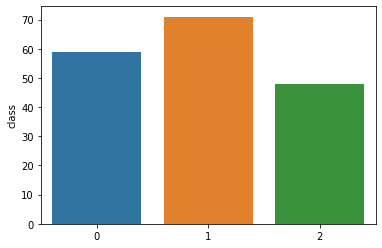

In [38]:
# 막대 그래프 생성 및 출력
sns.barplot(x=data['class'].value_counts().index, y=data['class'].value_counts())

x축과 y축을 각각 지정해줌

In [39]:
data['class'].value_counts().index

Int64Index([1, 0, 2], dtype='int64')

C:\Users\boo\anaconda3\envs\py36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='class', ylabel='count'>

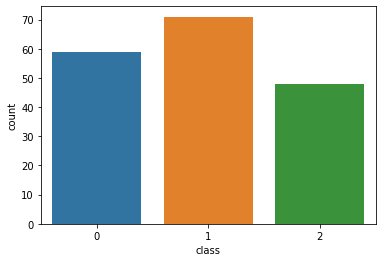

In [40]:
sns.countplot(data['class']) # countplot을 이용하여 더 쉽게 구현

<AxesSubplot:xlabel='class', ylabel='count'>

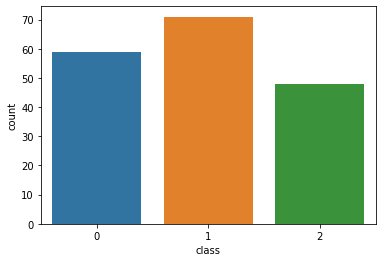

In [41]:
sns.countplot(x="class", data=data) # seaborn 버전에 대한 경고로 수정

### 전처리

In [42]:
# 결측치 확인
data.isna()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,False,False,False,False,False,False,False,False,False,False,False,False,False,False
174,False,False,False,False,False,False,False,False,False,False,False,False,False,False
175,False,False,False,False,False,False,False,False,False,False,False,False,False,False
176,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [43]:
# 변수별 합 출력
data.sum()

alcohol                           2286.080000
malic_acid                         415.870000
ash                                421.240000
alcalinity_of_ash                 3470.100000
magnesium                        17754.000000
total_phenols                      408.530000
flavanoids                         361.210000
nonflavanoid_phenols                62.690000
proanthocyanins                    283.180000
color_intensity                    900.339999
hue                                170.426000
od280/od315_of_diluted_wines       464.880000
proline                         132947.000000
class                              167.000000
dtype: float64

In [44]:
# isna와 sum을 조합하여 변수별 결측치 개수 확인
data.isna().sum()

alcohol                         2
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            5
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
class                           0
dtype: int64

In [45]:
data.isnull().sum() # isna()와 같은 방식

alcohol                         2
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            5
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
class                           0
dtype: int64

In [46]:
data.mean() # 평균 출력

alcohol                          12.989091
malic_acid                        2.336348
ash                               2.366517
alcalinity_of_ash                19.494944
magnesium                        99.741573
total_phenols                     2.295112
flavanoids                        2.029270
nonflavanoid_phenols              0.362370
proanthocyanins                   1.590899
color_intensity                   5.058090
hue                               0.957449
od280/od315_of_diluted_wines      2.611685
proline                         746.893258
class                             0.938202
dtype: float64

In [47]:
data.isna().mean() # 결측치의 비율 확인

alcohol                         0.011236
malic_acid                      0.000000
ash                             0.000000
alcalinity_of_ash               0.000000
magnesium                       0.000000
total_phenols                   0.000000
flavanoids                      0.000000
nonflavanoid_phenols            0.028090
proanthocyanins                 0.000000
color_intensity                 0.000000
hue                             0.000000
od280/od315_of_diluted_wines    0.000000
proline                         0.000000
class                           0.000000
dtype: float64

alcohol은 약 1.12%, nonflavanoid_phenols는 약 2.81%의 결측치가 있음

#### 1. 결측치 행 제거하기
- dropna()

In [48]:
data.dropna()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,2
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,2
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,2
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,2


7줄이 삭제됨
> alcohol과 nonflavanoid_phenols의 결측치가 각각 다른 줄에 있었기 때문

In [49]:
# 결측치가 지워졌는지 확인
data.dropna().isna().mean()

alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         0.0
class                           0.0
dtype: float64

In [50]:
# data=data.dropna()
# data.dropna(inplace=True) 
# 두 코드 모두 결측치 행을 지운 후 저장함

In [51]:
data.dropna(subset=['alcohol']) # alcohol이 결측인 행만 지움

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,2
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,2
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,2
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,2


In [52]:
data.dropna(subset=['alcohol']).isna().mean()

alcohol                         0.000000
malic_acid                      0.000000
ash                             0.000000
alcalinity_of_ash               0.000000
magnesium                       0.000000
total_phenols                   0.000000
flavanoids                      0.000000
nonflavanoid_phenols            0.028409
proanthocyanins                 0.000000
color_intensity                 0.000000
hue                             0.000000
od280/od315_of_diluted_wines    0.000000
proline                         0.000000
class                           0.000000
dtype: float64

nonflavanoid_phenols만 결측치가 존재함

#### 2. 결측 변수 제거하기: drop()

In [53]:
data.drop(['alcohol', 'nonflavanoid_phenols'], axis=1)

,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,1.71,2.43,15.6,127,2.80,3.06,2.29,5.64,1.04,3.92,1065,0
1,1.78,2.14,11.2,100,2.65,2.76,1.28,4.38,1.05,3.40,1050,0
2,2.36,2.67,18.6,101,2.80,3.24,2.81,5.68,1.03,3.17,1185,0
3,1.95,2.50,16.8,113,3.85,3.49,2.18,7.80,0.86,3.45,1480,0
4,2.59,2.87,21.0,118,2.80,2.69,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...
173,5.65,2.45,20.5,95,1.68,0.61,1.06,7.70,0.64,1.74,740,2
174,3.91,2.48,23.0,102,1.80,0.75,1.41,7.30,0.70,1.56,750,2
175,4.28,2.26,20.0,120,1.59,0.69,1.35,10.20,0.59,1.56,835,2
176,2.59,2.37,20.0,120,1.65,0.68,1.46,9.30,0.60,1.62,840,2


#### 3. 결측값 채우기: fillna()

일반적으로 평균값이나 중윗값을 이용

In [54]:
data.fillna(-99) # 임의값 -99로 결측치를 채움

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,-99.00,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,2
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,2
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,2
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,2


In [55]:
data.fillna(data.mean()) # 평균값으로 결측치 채우기

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.230000,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,12.989091,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.160000,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.370000,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.240000,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.710000,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,2
174,13.400000,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,2
175,13.270000,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,2
176,13.170000,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,2


In [56]:
data.mean()

alcohol                          12.989091
malic_acid                        2.336348
ash                               2.366517
alcalinity_of_ash                19.494944
magnesium                        99.741573
total_phenols                     2.295112
flavanoids                        2.029270
nonflavanoid_phenols              0.362370
proanthocyanins                   1.590899
color_intensity                   5.058090
hue                               0.957449
od280/od315_of_diluted_wines      2.611685
proline                         746.893258
class                             0.938202
dtype: float64

alcohol만의 평균값으로 채워진 것을 확인할 수 있음

#### 결측치 처리 방식 선택
- 일반적으로는 dropna()를 사용하여 결측치 해을 지우는 것
- 평균, 중윗값을 이용하여 결측치를 채우면, 아무리 비슷한 값을 채운다고 할지라도 실제값과 일치할 가능성이 낮음
    - 오차의 원인이 될 수 있어 노이즈가 더해진 효과를 냄
- dropna()의 단점
    - 결측값이 많다면 과도하게 데이터가 삭제될 수 있음
    - 그렇기에 drop()은 매우 무모한 선택일 수 있음
- drop()을 택하는 경우
    - 결측치가 50%이상이면 고려해볼만함
    - 결측치가 70~80% 이상이라면 가급적 drop()을 적용
    - 하지만, 결측치 자체가 의미있는 변수일 가능성이 있음

결측치 처리 방식으로 가장 가까운 K개의 이웃(KNN) 값을 평균해서 채움 KNNImpute도 있음
- 이외의 다양한 방식의 결측치 처리 방식이 있음

결측치를 채우려고하는 노력과 시간에 비해 대표값으로 처리하는 것이 더 나은 결과를 보여주는 경우가 많아 대표값으로 처리하는 경우가 많음

In [57]:
data.fillna(data.median(), inplace=True) # 결측치를 중앙값으로 채움

In [58]:
data.isna().mean()

alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         0.0
class                           0.0
dtype: float64

결측치가 잘 처리되었다는 것을 확인

### 스케일링

각 컬럼마다 범위가 다르기에 이러한 컬럼들의 범위를 맞춰주는 것을 스케일링이라함

스케일링 종류
- 표준화 스케일링: 평균이 0이 되고, 표준편차가 1이 되도록 데이터를 고르게 분포시키는데 사용
- 로버스트 스케일링: 데이터에 아웃라이어가 존재하고, 그 영향력을 그대로 유지하고 싶을 때 사용
- 최소-최대 스케일링: 데이터 분포의 특성을 최대한 그대로 유지하고 싶을 때 사용
- 정규화 스케일링: 행 기준의 스케일링이 필요할 때 사용하나, 실제로 거의 사용하지 않음

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#### 표준화 스케일링

In [60]:
st_scaler = StandardScaler() # 스케일러 지정

In [61]:
st_scaler.fit(data) # 학습

StandardScaler()

In [62]:
st_scaled=st_scaler.transform(data) # 학습에서 얻은 정보 계산

In [63]:
st_scaled

array([[ 1.55484903, -0.5622498 ,  0.23205254, ...,  1.84791957,
         1.01300893, -1.21394365],
       [ 0.07550273, -0.49941338, -0.82799632, ...,  1.1134493 ,
         0.96524152, -1.21394365],
       [ 0.21340789,  0.02123125,  1.10933436, ...,  0.78858745,
         1.39514818, -1.21394365],
       ...,
       [ 0.35131305,  1.74474449, -0.38935541, ..., -1.48544548,
         0.28057537,  1.37386437],
       [ 0.22594472,  0.22769377,  0.01273209, ..., -1.40069891,
         0.29649784,  1.37386437],
       [ 1.4294807 ,  1.58316512,  1.36520822, ..., -1.42894777,
        -0.59516041,  1.37386437]])

In [64]:
# 사람이 읽는 데이터라 numpy보단 pandas로 변형
pd.DataFrame(st_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.554849,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.658865,1.224884,0.251717,0.362177,1.847920,1.013009,-1.213944
1,0.075503,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820072,-0.544721,-0.293321,0.406051,1.113449,0.965242,-1.213944
2,0.213408,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.497658,2.135968,0.269020,0.318304,0.788587,1.395148,-1.213944
3,1.730365,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981279,1.032155,1.186068,-0.427544,1.184071,2.334574,-1.213944
4,0.313703,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.227773,0.401404,-0.319276,0.362177,0.449601,-0.037874,-1.213944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.902934,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.275618,-0.930179,1.142811,-1.392758,-1.231206,-0.021952,1.373864
174,0.514292,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.550187,-0.316950,0.969783,-1.129518,-1.485445,0.009893,1.373864
175,0.351313,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.550187,-0.422075,2.224236,-1.612125,-1.485445,0.280575,1.373864
176,0.225945,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.356221,-0.229346,1.834923,-1.568252,-1.400699,0.296498,1.373864


In [65]:
st_scaled = pd.DataFrame(st_scaled, columns = data.columns)

표준화 스케일링은 데이터를 표준화된 정규분포로 만들어주는 방법

In [66]:
round(st_scaled.describe(),2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.46,-1.43,-3.68,-2.67,-2.09,-2.11,-1.70,-1.87,-2.07,-1.63,-2.09,-1.90,-1.49,-1.21
25%,-0.79,-0.66,-0.57,-0.69,-0.82,-0.89,-0.83,-0.74,-0.60,-0.80,-0.77,-0.95,-0.78,-1.21
50%,0.08,-0.42,-0.02,0.00,-0.12,0.10,0.11,-0.18,-0.06,-0.16,0.03,0.24,-0.23,0.08
75%,0.84,0.67,0.70,0.60,0.51,0.81,0.85,0.61,0.63,0.49,0.71,0.79,0.76,1.37
max,2.21,3.11,3.16,3.15,4.37,2.54,3.06,2.40,3.49,3.44,3.30,1.96,2.97,1.37


평균이 0, 표준편차가 1인 것을 확인할 수 있음

#### 로버스트 스케일링

In [67]:
rb_scaler = RobustScaler()

In [68]:
rb_scaled = rb_scaler.fit_transform(data)
rb_scaled = pd.DataFrame(rb_scaled, columns=data.columns)

In [69]:
round(rb_scaled.describe(),2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,-0.05,0.32,0.02,-0.00,0.09,-0.06,-0.06,0.13,0.05,0.12,-0.02,-0.14,0.15,-0.03
std,0.62,0.75,0.79,0.78,0.75,0.59,0.60,0.74,0.82,0.78,0.68,0.58,0.65,0.39
min,-1.55,-0.76,-2.88,-2.07,-1.47,-1.30,-1.07,-1.25,-1.64,-1.14,-1.44,-1.23,-0.82,-0.50
25%,-0.53,-0.18,-0.43,-0.53,-0.53,-0.58,-0.56,-0.42,-0.44,-0.49,-0.54,-0.68,-0.36,-0.50
50%,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
75%,0.47,0.82,0.57,0.47,0.47,0.42,0.44,0.58,0.56,0.51,0.46,0.32,0.64,0.50
max,1.31,2.66,2.50,2.44,3.37,1.44,1.76,1.91,2.89,2.79,2.21,0.99,2.08,0.50


사분위값에 의해 스케일링 되어 평균은 0에 가깝지만 0은 아니고, 분산 또한 1로 고정되지 않음

### 최소-최대 스케일링

In [70]:
mm_scaler = MinMaxScaler()
mm_scaled = mm_scaler.fit_transform(data)
mm_scaled = pd.DataFrame(mm_scaled, columns=data.columns)
round(mm_scaled.describe(),2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,0.53,0.32,0.54,0.46,0.32,0.45,0.36,0.44,0.37,0.32,0.39,0.49,0.33,0.47
std,0.22,0.22,0.15,0.17,0.16,0.22,0.21,0.23,0.18,0.20,0.19,0.26,0.22,0.39
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.36,0.17,0.45,0.34,0.20,0.26,0.18,0.26,0.26,0.17,0.25,0.24,0.16,0.00
50%,0.54,0.22,0.53,0.46,0.30,0.47,0.38,0.40,0.36,0.29,0.39,0.55,0.28,0.50
75%,0.71,0.46,0.64,0.56,0.40,0.63,0.53,0.58,0.49,0.42,0.52,0.70,0.50,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


최댓값이 1, 최솟값이 0인 형태로 변환되는 스케일러

#### 스케일링 방식 선택하기
- 아웃라이어의 영향이 큰 데이터이고 이를 피하고 싶다 >> 로버스트 스케일링
    - 표준화와 최소-최대는 이상치에 민감하게 반응
- 기존 분포를 최대한 유지하여 스케일링 >> 최소-최대 스케일링
    - 표준화의 경우 모든 데이터를 정규분포로 만들어 좌우 대칭의 종모양으로 변경
- 기존 데이터가 정규분포를 따르고, 아웃라이어가 없는 상황 >> 표준화 스케일링

#### 주의사항
- 스케일링 대상에서 종속변수를 제외
- 스케일링 전에 훈련셋과 시험셋을 나누어야함

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('class', axis=1), data['class'], test_size=0.2, random_state=100)

In [72]:
# 데이터의 특성을 그대로 보존하기 위해 최대-최소 스케일러 사용
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)

MinMaxScaler()

In [73]:
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [74]:
# 같은 방식
# mm_scaler = MinMaxScaler()
# X_trained_scaled = mm.scaler.fit_transform(X_train)
# X_test_scaled = mm_scaler.fit_transform(X_test)

### 모델링 및 예측/평가하기

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)

In [77]:
pred

array([1, 2, 0, 1, 2, 2, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 1, 0, 2, 0,
       2, 1, 0, 0, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2], dtype=int64)

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8888888888888888

약 89%의 정확도로 괜찮은 수준의 예측

### 하이퍼파라미터 튜닝

기본값
- n_neighbors = 5 : 예측에 참고할 이웃수
- weights='uniform': 예측에 사용되는 가중치 함
    - uniform : 동일 가중치
    - distance : 가까울 수록 높은 가중치
    - 사용자 정의 함수
- metric='minkowski : 거리 측정 기준
    - minkowski : 유클리드 거리
- n_jobs=None : 실행할 병렬 작업 수

In [79]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)
accuracy_score(y_test, pred)

0.9166666666666666

In [80]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)
accuracy_score(y_test, pred)

0.8888888888888888

n_neighbors에 들어가는 숫자가 달라지면 예측 결과 또한 달라질 수 있기에 하나하나 확인하기는 불편함

In [81]:
# 적당한 범위의 반복문으로 예측값 확인
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred = knn.predict(X_test_scaled)
    print(accuracy_score(y_test, pred))

0.9166666666666666
0.8888888888888888
0.8888888888888888
0.9166666666666666
0.8888888888888888
0.9166666666666666
0.9166666666666666
0.8888888888888888
0.8888888888888888
0.8888888888888888
0.9166666666666666
0.9166666666666666
0.9722222222222222
0.9444444444444444
0.9444444444444444
0.9444444444444444
0.9166666666666666
0.9722222222222222
0.9444444444444444
0.9722222222222222


In [82]:
# 그래프를 그리기 위해 리스트에 저장
scores=[]

for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred = knn.predict(X_test_scaled)
    acc=accuracy_score(y_test, pred)
    scores.append(acc)

In [83]:
scores

[0.9166666666666666,
 0.8888888888888888,
 0.8888888888888888,
 0.9166666666666666,
 0.8888888888888888,
 0.9166666666666666,
 0.9166666666666666,
 0.8888888888888888,
 0.8888888888888888,
 0.8888888888888888,
 0.9166666666666666,
 0.9166666666666666,
 0.9722222222222222,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9166666666666666,
 0.9722222222222222,
 0.9444444444444444,
 0.9722222222222222]

<AxesSubplot:>

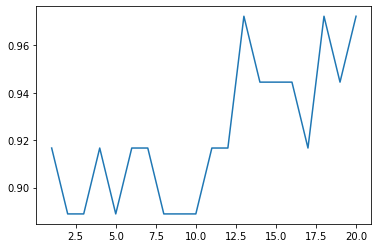

In [84]:
sns.lineplot(x=range(1,21), y=scores)

매개변수 값이 클수록 더욱 나은 예측을 보여주지만 13 이후로는 개선이 없음
- 매개변수가 값이 클수록 연산이 많기에 높은 예측 결과 중 매개변수 값이 낮은 13이 합리적인 선택
- n_neighbor = 13 으로 지정

In [85]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)
accuracy_score(y_test, pred)

0.9722222222222222

- KNN은 인접한 이웃의 개수를 통해 분류하는데, 개수가 같을 경우 사이킷런에서는 랜덤으로 분류
    - 고려할 이웃의 수를 항상 홀수개로 유지하면 동점 문제를 해결 할 수 있음
    - 가중치를 주어 거리가 가까운 쪽으로 설정할 수 있음

## 질문

스케일링은 훈련셋에 스케일러를 fit하여 평균과 표준편차를 학습하고 같은 기준으로 훈련셋과 테스트셋을 transform 합니다. 그런데 훈련셋과 테스트셋의 분포가 크게 다를 경우에도 추가적인 처리 없이 동일한 Scaler를 그대로 사용하는 것이 맞는지 궁금합니다.